#ENSIAS 2023
#Socila Network Analysis
#Sentiment Analysis using BERT Darija 
we will try in this notebook to use the data we have already collected in our (souk de entrepreneurs) group
in ordre to predict the sentiments of commenters on the post (positive,negative or neutral)

BERT (Bidirectionnal Encoder Representations for Transformers) is a “new method of pre-training language representations” developed by Google and released in late 2018.

### Import Libraries and Set the intial variables

In [ ]:
!pip install transformers googletrans==3.1.0a0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 65.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.3 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16368 sha256=44d2d25d7887c86eb023fcb1d8d5b211b73a23acc686

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import googletrans
from googletrans import Translator
# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from tqdm import *
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
# Misc.
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: ignored

In [ ]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'
# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load the data

In [165]:
df = pd.read_csv('Sentiment_Anaysis.csv')
df = df.rename(columns={'Twits': 'text'})
conditions = [df['label'].eq('pos'),df['label'].eq('neu'),df['label'].eq('neg')]
choices = [2,1,0]
df['sentiment'] = np.select(conditions, choices, default=0)
df

,Unnamed: 0,text,label,sentiment
0,0,what happens,neu,1
1,1,😞😞,neg,0
2,2,ان شاء الله,neu,1
3,3,بالتوفيق ان شاء الله,pos,2
4,4,الحمدلله على كل حال,pos,2
...,...,...,...,...
52205,52205,هاي باهي وليت تفهم في اللبسة متاع الرجال 🤔🤔,neu,1
52206,52206,ريي يصبر امها,neu,1
52207,52207,اللهم امين يارب العالمين ربي يصبر أهلهم,pos,2
52208,52208,اللهم امين يارب العالمين مخيبها عواشر لا حول و...,pos,2


We can see that the most relevant column for us is content and replyContent and the score as well.

In [166]:
# Let's check for missing values 
df.isnull().sum()

Unnamed: 0    0
text          0
label         0
sentiment     0
dtype: int64

We can see that we have more positive classes than negative and low number of neutral class. I have kept neutral less to focus more on positive and negative classes. Let's allot classes based on scores now. 

* 0 - negative
* 1 - neutral 
* 2 - positive

[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

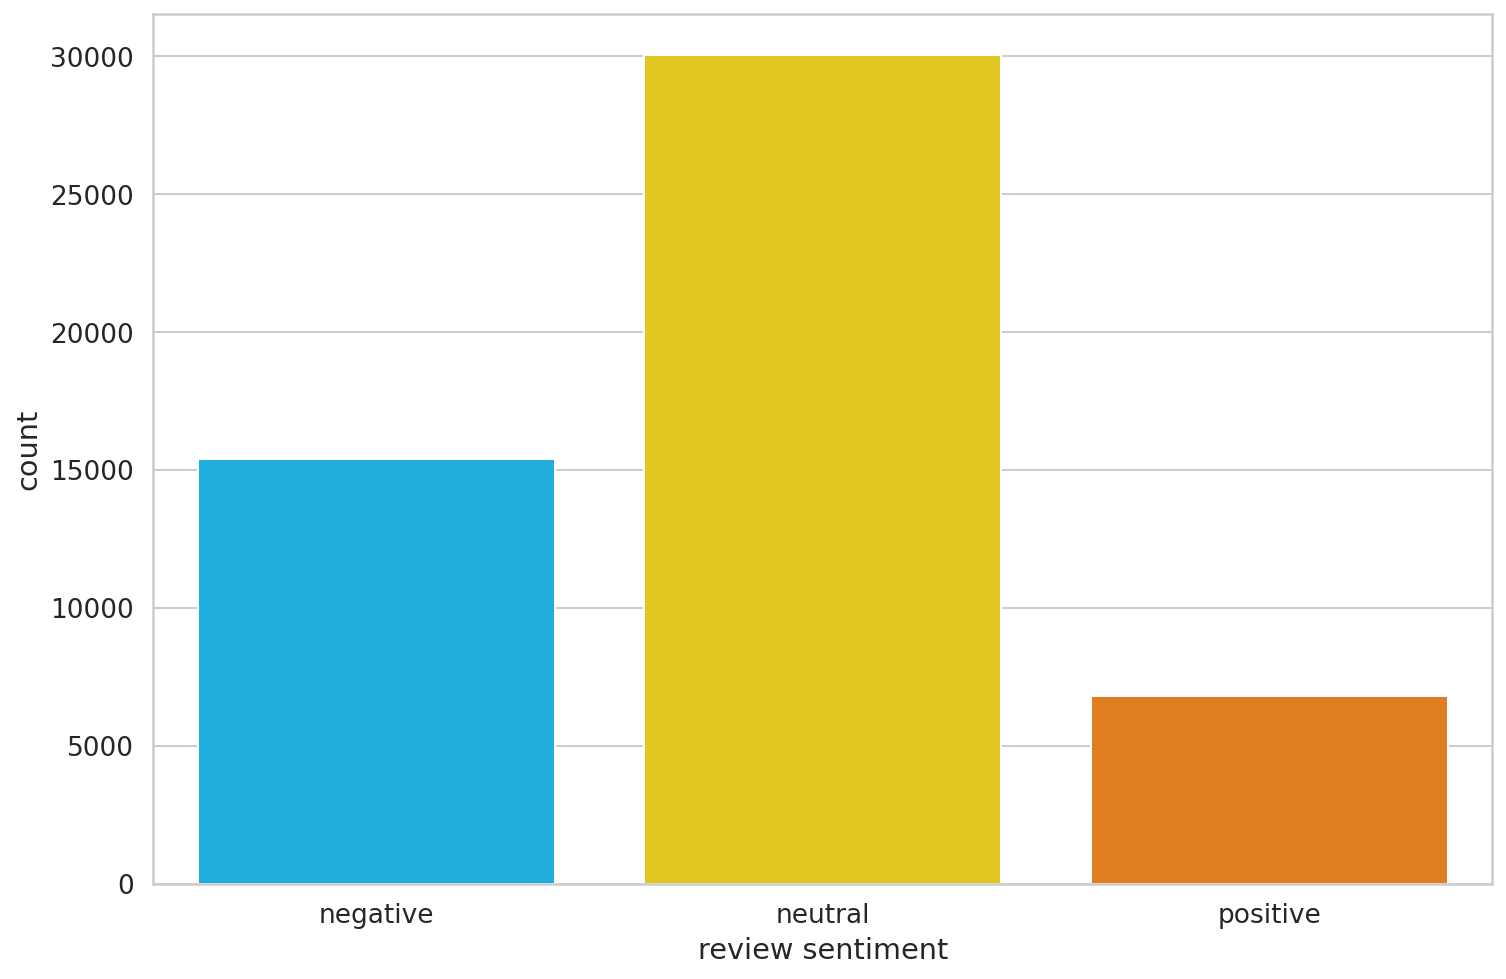

In [167]:
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

In [ ]:
# Plot the distribution
class_names = ['Colture', 'Diverse', 'Economy', 'Politic', 'Sport']
ax = sns.countplot(df.Tag)
df['sentiment']=df['Tag']
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

## Data Preprocessing

Machine Learning models don’t work with raw text. You need to convert text to numerical representation. BERT requires even more attention when it comes to this representation. 

Here are the requirements:

* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called attention mask

BERT offers a few model architectures and I will be using one of them combined with manual preprocessing. I am using the cased version which considers GREAT and great to be to different entities and BAD might be given more focus than bad.  

The tokenizer will break the sentence into words and give numerical values to each word. 

In [ ]:
# Set the model name
# MODEL_NAME = 'bert-base-cased'
# MODEL_NAME ='aubmindlab/bert-base-arabertv02'
MODEL_NAME='SI2M-Lab/DarijaBERT'
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("SI2M-Lab/DarijaBERT")
bert_model = AutoModel.from_pretrained("SI2M-Lab/DarijaBERT")
# Build a BERT based tokenizer
# tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


Some weights of the model checkpoint at SI2M-Lab/DarijaBERT were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at SI2M-Lab/DarijaBERT and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You

In [ ]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 3
[CLS] 2
[PAD] 0
[UNK] 1


In [ ]:
import re
import string
# ''''`÷×؛ç<>_()*&^%][ـ،/:"؟.,'{}~ ⃣¦+éèûà([@-z0-9_]+)|[^\w\s]|#|http\S+\n0123456789''''
arabic_punctuations = '''`•²÷×؛’ôâêâ«»<>()*&^%]î€[ـ،/:"؟.,|!”…“–ـ﷿🤔'{}~¦œ+|!”…“–ـ🤔éèûà([@-z0-9_]+)|[^\w\s]|#|http\S+\n0123456789'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
emojis = re.compile(pattern = "["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"  
                           "]+", flags = re.UNICODE)


def all_pre(text,lettres=False):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("_"," ", text)
    text = re.sub("گ", "ك", text)
    text = re.sub(arabic_diacritics, '', text)
    if lettres:
      text = re.sub(r'[a-z]','', text.lower())
      text = re.sub(r'(.)\1+', r'\1', text)
      translator = str.maketrans('', '', punctuations_list)
      text = text.translate(translator)
    text = emojis.sub(r'',text)
    return text
    

In [ ]:
df.replace(' ', np.nan, inplace=True)
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(inplace=True,drop=True)
# df.drop('Unnamed: 0',axis=1,inplace=True)
display(df)
# df.to_json('predarija.json')

,Unnamed: 0,Twits,label,sentiment
0,0,ما يحدث,neu,1
1,2,ان شاء الله,neu,1
2,3,بالتوفيق ان شاء الله,pos,2
3,4,الحمدلله علي كل حال,pos,2
4,5,الله يستر,neu,1
...,...,...,...,...
50355,52205,هاي باهي وليت تفهم في اللبسه متاع الرجال 🤔🤔,neu,1
50356,52206,ريي يصبر امها,neu,1
50357,52207,اللهم امين يارب العالمين ربي يصبر اهلهم,pos,2
50358,52208,اللهم امين يارب العالمين مخيبها عواشر لا حول و...,pos,2


In [ ]:
for i,row in df.iterrows():
    df['text'][i]=all_pre(row['text'])
display(df)    


,Unnamed: 0,Twits,label,sentiment
0,0,what happens,neu,1
1,1,,neg,0
2,2,ان شاء الله,neu,1
3,3,بالتوفيق ان شاء الله,pos,2
4,4,الحمدلله علي كل حال,pos,2
...,...,...,...,...
52205,52205,هاي باهي وليت تفهم في اللبسه متاع الرجال 🤔🤔,neu,1
52206,52206,ريي يصبر امها,neu,1
52207,52207,اللهم امين يارب العالمين ربي يصبر اهلهم,pos,2
52208,52208,اللهم امين يارب العالمين مخيبها عواشر لا حول و...,pos,2


In [ ]:
for i,row in df.iterrows():
  # print(any(c.isalpha() for c in df['text'][i]))
  if re.search('[a-zA-Z]', df['text'][i])!=None:
    df['text'][i]=all_pre(df['text'][i])
    translator = Translator()
    translated = translator.translate(df['text'][i],src='FR', dest='arabic')
    df['text'][i]=translated.text
    translated = translator.translate(df['text'][i],src='EN', dest='arabic')
    df['text'][i]=all_pre(translated.text,lettres=True)
    print(df['text'][i])


In [ ]:
display(df)
for i ,row in df.iterrows():
  if not any(c.isalpha() for c in df['text'][i]):
    df=df.drop(i)
df.reset_index(inplace=True,drop=True)
display(df)

,Unnamed: 0,Twits,label,sentiment
0,0,ما يحدث,neu,1
1,1,,neg,0
2,2,ان شاء الله,neu,1
3,3,بالتوفيق ان شاء الله,pos,2
4,4,الحمدلله علي كل حال,pos,2
...,...,...,...,...
52205,52205,هاي باهي وليت تفهم في اللبسه متاع الرجال 🤔🤔,neu,1
52206,52206,ريي يصبر امها,neu,1
52207,52207,اللهم امين يارب العالمين ربي يصبر اهلهم,pos,2
52208,52208,اللهم امين يارب العالمين مخيبها عواشر لا حول و...,pos,2


,Unnamed: 0,Twits,label,sentiment
0,0,ما يحدث,neu,1
1,2,ان شاء الله,neu,1
2,3,بالتوفيق ان شاء الله,pos,2
3,4,الحمدلله علي كل حال,pos,2
4,5,الله يستر,neu,1
...,...,...,...,...
50355,52205,هاي باهي وليت تفهم في اللبسه متاع الرجال 🤔🤔,neu,1
50356,52206,ريي يصبر امها,neu,1
50357,52207,اللهم امين يارب العالمين ربي يصبر اهلهم,pos,2
50358,52208,اللهم امين يارب العالمين مخيبها عواشر لا حول و...,pos,2


In [ ]:
df.to_json('datapre.json')

In [ ]:
df=pd.read_json('datapre.json')
display(df)

,Unnamed: 0,Twits,label,sentiment
0,0,ما يحدث,neu,1
1,2,ان شاء الله,neu,1
2,3,بالتوفيق ان شاء الله,pos,2
3,4,الحمدلله علي كل حال,pos,2
4,5,الله يستر,neu,1
...,...,...,...,...
50355,52205,هاي باهي وليت تفهم في اللبسه متاع الرجال 🤔🤔,neu,1
50356,52206,ريي يصبر امها,neu,1
50357,52207,اللهم امين يارب العالمين ربي يصبر اهلهم,pos,2
50358,52208,اللهم امين يارب العالمين مخيبها عواشر لا حول و...,pos,2


In [ ]:
# Store length of each review 
token_lens = []
# Iterate through the content slide
for txt in df.text:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review.

Text(0.5, 0, 'Token count')

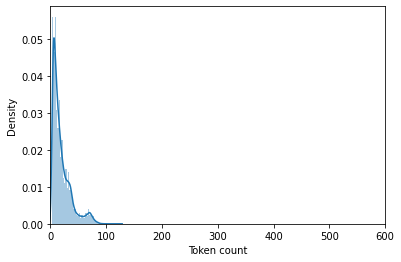

In [ ]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 600]);
plt.xlabel('Token count')

Most of the reviews seem to contain less than 120 tokens, but we’ll be on the safe side and choose a maximum length of 160. 

In [ ]:
MAX_LEN = 120

### Preparing Torch Dataset

To enter data into a PyTorch, we need a more robust data generator class. We will return the review text as well to validate our predictions easily. 

In [ ]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

**Create** a 90% train data and 5% test and 5% validation data

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(45324, 4) (2518, 4) (2518, 4)


Create a dataloader to release data in batches.

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.text.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [ ]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 120])
torch.Size([16, 120])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

We’ll use the basic BertModel and build our sentiment classifier on top of it. Let’s load the model

In [ ]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)
# bert_model = AutoModel.from_pretrained("SI2M-Lab/DarijaBERT")


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Some weights of the model checkpoint at SI2M-Lab/DarijaBERT were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not 

In [ ]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        # self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask ,return_dict=False):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

We use a dropout layer for some regularization and a fully-connected layer for our output. We are returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work. Create an instance and move it to the GPU

In [ ]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Some weights of the model checkpoint at SI2M-Lab/DarijaBERT were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not 

#### Model Characterstics

In [ ]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


### Training Phase

we’ll use the AdamW optimizer provided by Hugging Face. It corrects weight decay. We’ll also use a linear scheduler with no warmup

In [ ]:
# Number of iterations 
EPOCHS = 1

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

Write a function to evaluate model performance

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                return_dict=False
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

Write the training Loop and store the best training state.

In [33]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    

Epoch 1/5
----------


100%|██████████| 2833/2833 [15:47<00:00,  2.99it/s]


Train loss 0.469943915122638 accuracy 0.8203821374988969
Val   loss 0.41823053227949747 accuracy 0.8339952343129468

Epoch 2/5
----------


100%|██████████| 2833/2833 [15:48<00:00,  2.99it/s]


Train loss 0.34276954083319816 accuracy 0.8752537287088519
Val   loss 0.45590661095950424 accuracy 0.8335980937251787

Epoch 3/5
----------


100%|██████████| 2833/2833 [15:47<00:00,  2.99it/s]


Train loss 0.2470565886447779 accuracy 0.9220721913335099
Val   loss 0.6161396048338259 accuracy 0.8308181096108022

Epoch 4/5
----------


100%|██████████| 2833/2833 [15:47<00:00,  2.99it/s]


Train loss 0.1777265756873005 accuracy 0.9491439413997
Val   loss 0.8000017419587113 accuracy 0.8236695790309769

Epoch 5/5
----------


100%|██████████| 2833/2833 [15:47<00:00,  2.99it/s]


Train loss 0.1378420086031332 accuracy 0.9631762421675051
Val   loss 0.8606010680484786 accuracy 0.830023828435266

CPU times: user 55min 2s, sys: 24min 32s, total: 1h 19min 34s
Wall time: 1h 20min 20s


The above took a lot of time but it's finally working. Now, we can plot the training and validation accuracy.

defaultdict(<class 'list'>, {'train_acc': [0.8203821374988969, 0.8752537287088519, 0.9220721913335099, 0.9491439413997, 0.9631762421675051], 'train_loss': [0.469943915122638, 0.34276954083319816, 0.2470565886447779, 0.1777265756873005, 0.1378420086031332], 'val_acc': [0.8339952343129468, 0.8335980937251787, 0.8308181096108022, 0.8236695790309769, 0.830023828435266], 'val_loss': [0.41823053227949747, 0.45590661095950424, 0.6161396048338259, 0.8000017419587113, 0.8606010680484786]})


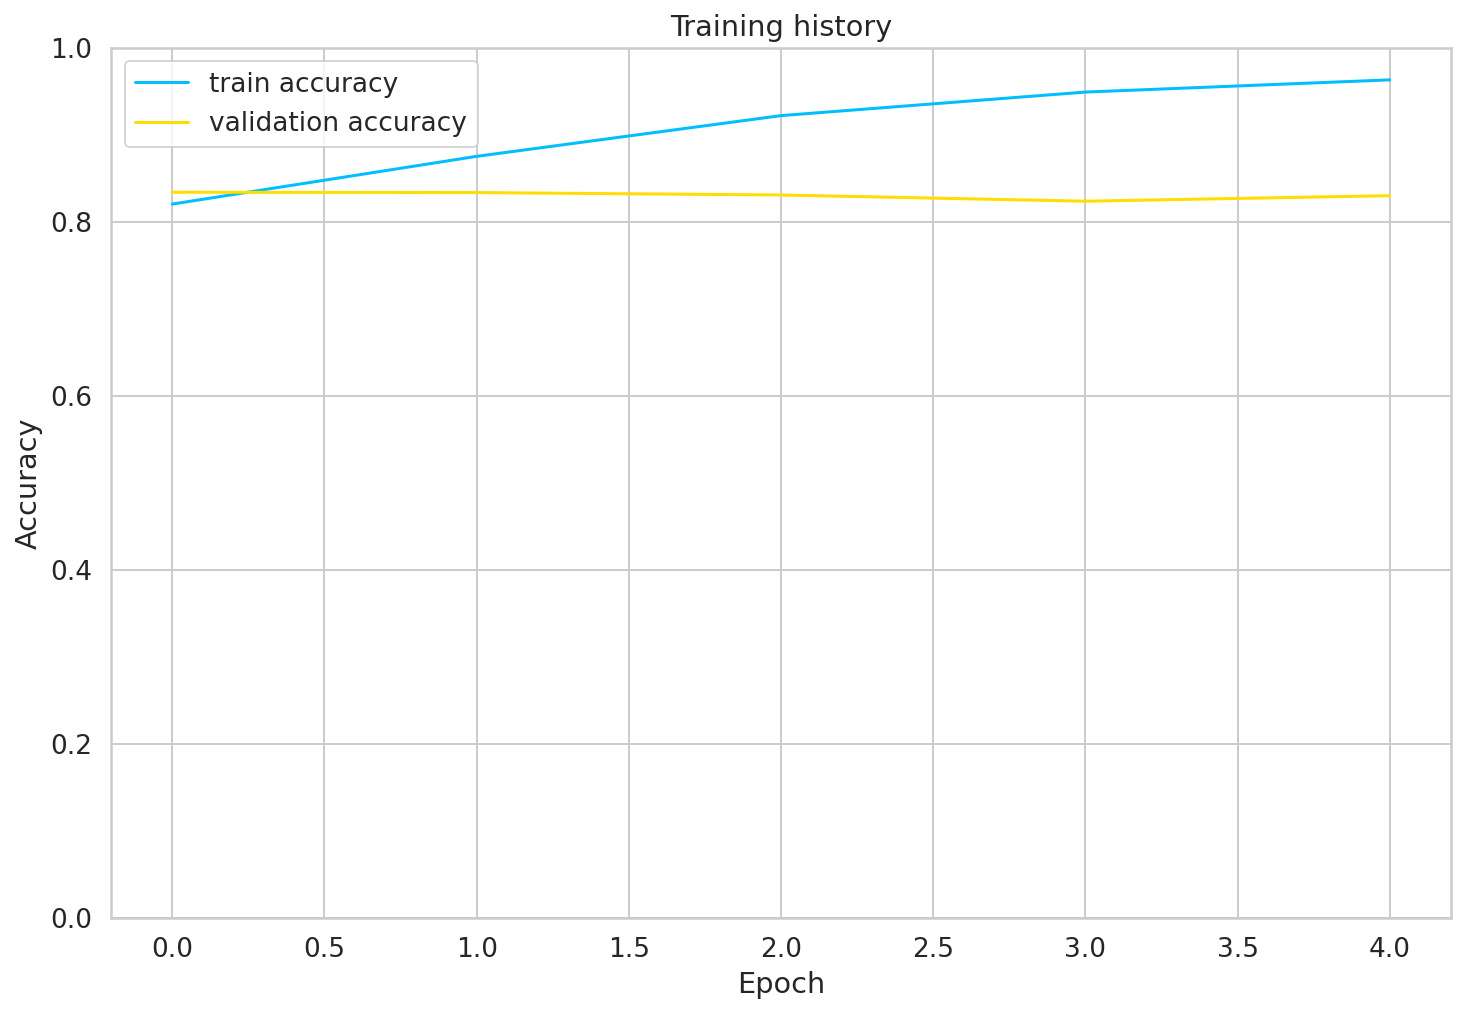

In [107]:
# Plot training and validation accuracy
histoory=defaultdict(list)
for i in range(5):
    histoory['train_acc'].append(history['train_acc'][i].item())
    histoory['train_loss'].append(history['train_loss'][i].item())
    histoory['val_acc'].append(history['val_acc'][i].item())
    histoory['val_loss'].append(history['val_loss'][i].item())
print(histoory)
plt.plot(histoory['train_acc'], label='train accuracy')
plt.plot(histoory['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
# index = output.cpu().data.numpy().argmax()

### Model Evaluation

In [108]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8506751389992057

Define a helper function to get predictions from our models. This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities

In [109]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [114]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [115]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.82      0.87      0.84       788
     neutral       0.87      0.88      0.88      1391
    positive       0.73      0.57      0.64       339

    accuracy                           0.84      2518
   macro avg       0.80      0.77      0.79      2518
weighted avg       0.83      0.84      0.83      2518



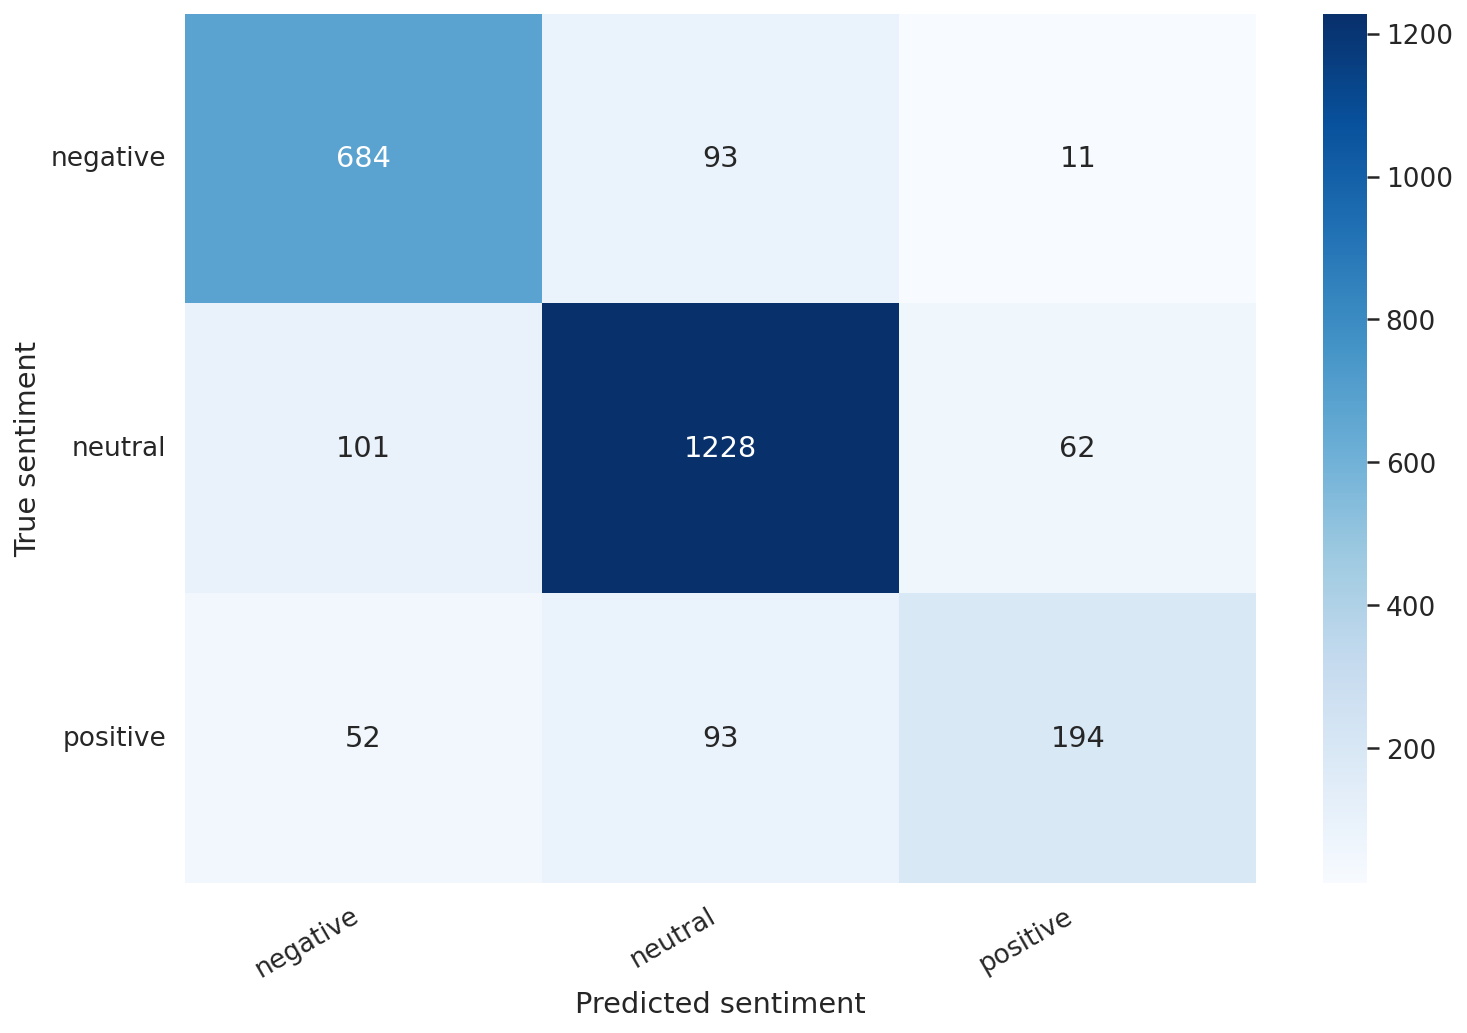

In [116]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That’s a good overview of the performance of our model.

## Predicting on raw text

In [ ]:
posts=pd.read_json('data.json')
h=1
comments=[]
comment_id=[]
for i,row in posts.iterrows():
  if posts['commenters_id'][i]!='no comment':
    for j in range(len(row['comments_full'])):
        k=row['comments_full'][j]
        comments.append(k['comment_text'])
        comment_id.append(k['comment_id'])
        for l in range(len(k['replies'])):
          comments.append(k['replies'][l]['comment_text'])
          comment_id.append(k['replies'][l]['comment_id'])
          # print(k['replies'][l]['comment_text'])
          # print(k['comment_text'])
# print(comments)
comments=pd.DataFrame(comments)
comments.columns=['text']
comment_id=pd.DataFrame(comment_id)
comment_id.columns=['comment_id']
result = comments.join(comment_id)
display(comments)
display(comment_id)
display(result)

In [89]:
import googletrans
from googletrans import Translator

# df1=pd.read_json('data.json')
# df1=pd.DataFrame(df1['text'])
df1=result
for i ,row in df1.iterrows():
  df1['text'][i]=all_pre(df1['text'][i])
  translator = Translator()
  translated = translator.translate(df1['text'][i] , dest='arabic')
  df1['text'][i]=translated.text
  translated = translator.translate(df1['text'][i], dest='arabic')
  df1['text'][i]=translated.text
  df1['text'][i]=all_pre(translated.text,lettres=True)
  if not any(c.isalpha() for c in df1['text'][i]):
    df1=df1.drop(i)
df1.reset_index(inplace=True,drop=True)
display(df1)

,text,comment_id
0,,5379722945430910
1,وانا عجبتني غير لحطه ديال طويكيه اما المقاوله ...,5599884196748116
2,لحطه ديال طويكيه تدل علي عدم الرضي و ديالي,5599909776745558
3,يكون خير خويا حسنالتغير صعيب لاسيما ملي تخدم ...,5599915726744963
4,اكيد اخي العزيز,5599919180077951
...,...,...
1043,ربما الفروع في اماكن استرتيجيه او اول مره تصل ...,5136830149720192
1044,كيفاش شراو منها الفرونشيز وهي كتحق خساءروكيفاش...,5137597046310169
1045,مهتم,5137898339613373
1046,علاقه مع زبناء,5137470079656199


In [117]:
# df1=result
df1['prediction']=0

MAX_LEN=120
for i , row in df1.iterrows():
  review_text=row['text']
  encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',)
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  df1['prediction'][i]=class_names[prediction]
display(df1)


[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

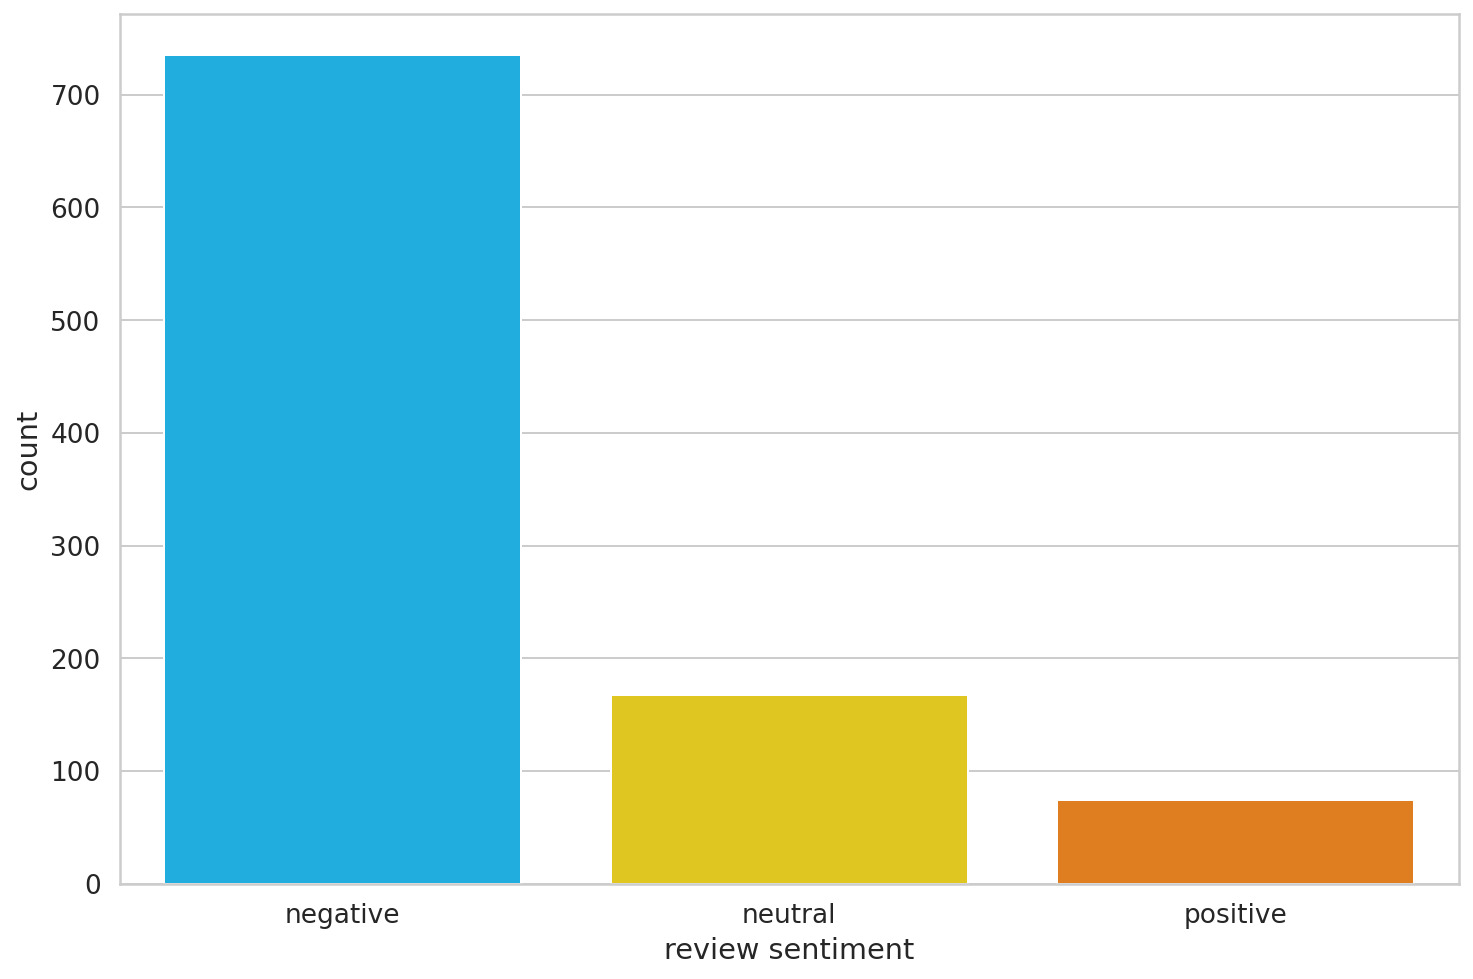

In [119]:
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df1.prediction)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

In [120]:
for i ,r in df1.iterrows():
  if r['prediction']=='positive':
    print(r['text'])
    print(i)

تقرير الابتكار الاجتماعي ليس صاحب المشروععلي موقع التواصل الاجتماعي في المغرب من انتاج مءسه عبد القادر بن صالح   محتوي تحميلات   تقرير 
13
راءع شكرا لك سي حسن عماد علي هذه المعلومه المذهله التي ترك عاجزا عن الكلام  
23
 احلي حسن اله يحفظك شكرا
71
بالتوفيق انشاء اله
81
شكرا لك لو حسن
88
شكرا
90
برنامج زوين بزاف انشاء اله المغرب قريبا
91
اله يوفقك اخي
105
كوتر بنخليفا اي و نتمني لي جاع وليده يكون صالحين يا رب
155
 اله يعزك
183
 اله يكبر بك تحياتي
201
 شكرا
210
شكرا علي المعلومات القيمه الفيشاوي جعلها اله في ميزان حسناتك في انتصار المزيد ان شاءاله
226
اله يبارك فيك
240
 اله يسخر الامور
248
امين ا سي حسن لينا كاملين يا ربي
249
 مبروك عليك و اله يوفق
301
اطال اله عمرك السي الفيزازي واله يرحم الوالدين علي المعلومات القيمه وحنا في انتضار الجديد ان شاء اله
329
نصيحه جات فوقتها سبحان له لعدم له اسهل عليك
331
راءع شكرا
356
فرصه طيبه نتلاقاو ان شاءاله
373
جزاك اله خيرا كثير هي قص الباحثين عن العملاله يهدي ما خلق
411
شكرا استاذي كلام في الصميم
413
تحيه لاستاذنا العزيز
431
مريم الاشقر شكرا لك
450
 

In [169]:
# review_text = "شكرا بزاف الله يحفظك اعشيري"
# review_text = "شكون غادي يجاوب علي هذا السءال"
translator = Translator()
review_text= translator.translate(review_text ,dest='arabic')
review_text=review_text.text
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: جريمة
Sentiment  : neutral
